In [1]:
# Reproducibility: fix random seeds and deterministic settings
import os
import random
import numpy as np
import torch

SEED = 42  # change if you need a different deterministic run

# For deterministic cublas (must be set before first CUDA op)
os.environ.setdefault('CUBLAS_WORKSPACE_CONFIG', ':4096:8')
# Make Python hashing deterministic
os.environ['PYTHONHASHSEED'] = str(SEED)

# Python, NumPy, PyTorch seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Deterministic CuDNN behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} (CUDA available: {torch.cuda.is_available()})")


Seeds set to 42 (CUDA available: True)


# diffusion_map_pair_features: 
测试 300 节点顺序链图 + 随机捷径(0–10) 时应取多少个前导分量 k

目的：
- 构造多组 300 节点的“顺序链(路径图)”并随机添加 0–10 条额外边，形成近似“链 + 少量捷径”的图。
- 使用 `BondFlow.data.utils.diffusion_map_pair_features` 计算特征与本征对，基于扩散映射在时间 t 的距离近似误差与谱能量占比，评估不同 k 的效果。
- 输出误差曲线、能量累计曲线，并给出推荐 k。


In [2]:
import os
import math
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

# Prefer absolute import within repo
from BondFlow.data.utils import diffusion_map_pair_features

# Reproducibility
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:70: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


Using device: cuda


In [3]:
def build_chain_with_shortcuts(L: int = 300, num_shortcuts: int = 0, undirected: bool = True):
    """
    Build an L-node chain (path) graph with num_shortcuts random additional edges.
    Returns adjacency matrix A (torch.float32, shape [L,L]).
    """
    A = torch.zeros((L, L), dtype=torch.float32)
    # chain edges
    for i in range(L-1):
        A[i, i+1] = 1.0
        A[i+1, i] = 1.0
    # random shortcuts
    if num_shortcuts > 0:
        # disallow duplicate and neighbors
        seen = set()
        attempts = 0
        while len(seen) < num_shortcuts and attempts < 10_000:
            i = np.random.randint(0, L)
            j = np.random.randint(0, L)
            if i == j or abs(i-j) <= 1:
                attempts += 1
                continue
            u, v = (i, j) if i < j else (j, i)
            if (u, v) in seen:
                attempts += 1
                continue
            seen.add((u, v))
            A[u, v] = 1.0
            A[v, u] = 1.0
            attempts += 1
    return A


def normalized_laplacian_from_adj(A: torch.Tensor) -> torch.Tensor:
    """Compute symmetric normalized Laplacian L_sym = I - D^{-1/2} A D^{-1/2}."""
    L = A.shape[0]
    d = A.sum(dim=-1)
    inv_sqrt_d = torch.where(d > 0, d.pow(-0.5), torch.zeros_like(d))
    S = inv_sqrt_d[:, None] * A * inv_sqrt_d[None, :]
    I = torch.eye(L, dtype=A.dtype, device=A.device)
    return I - S


def diffusion_distance_from_spectrum(lam: torch.Tensor, U: torch.Tensor, t: int) -> torch.Tensor:
    """
    Compute diffusion distance matrix at time t using top-k eigenpairs provided in lam (L,) and U (L,k).
    Note: Here we assume lam are eigenvalues of S (normalized adjacency), sorted descending, and U its eigenvectors.
    """
    # Use pair embedding [U * lam^t]
    lam_pow = lam.pow(int(t))  # (k,)
    emb = U * lam_pow[None, :]  # (L, k)
    # pairwise squared distances in embedding space
    # D_ij^2 = ||emb_i - emb_j||^2
    # Compute via ||x||^2 + ||y||^2 - 2 x·y
    sq = (emb**2).sum(dim=-1, keepdim=True)
    dist2 = sq + sq.transpose(0,1) - 2 * (emb @ emb.transpose(0,1))
    dist2 = torch.clamp(dist2, min=0)
    return torch.sqrt(dist2 + 1e-12)


def explained_energy(lam_full: torch.Tensor, k: int, skip_top: bool = True) -> float:
    """
    Legacy (not time-aware): sum of |lambda| over top-k divided by total after optional skip.
    Kept for reference.
    """
    start = 1 if skip_top else 0
    lam_abs = lam_full.abs()
    denom = lam_abs[start:].sum().item() + 1e-12
    numer = lam_abs[start:start+k].sum().item()
    return numer / denom


def explained_energy_t(lam_full: torch.Tensor, k: int, t: int, skip_top: bool = True) -> float:
    """
    Time-aware spectral energy for diffusion at time t.
    Uses weights |lambda|^(2t), matching the Frobenius norm of the diffusion kernel K_t.
    """
    start = 1 if skip_top else 0
    w = lam_full.abs().pow(2 * int(t))
    denom = w[start:].sum().item() + 1e-12
    numer = w[start:start+k].sum().item()
    return numer / denom


def compute_reference_spectrum(A: torch.Tensor, skip_top: bool = True):
    """
    Compute full-basis spectrum of normalized adjacency S for reference distances.
    Returns (lam_desc, U_desc)
    """
    L = A.shape[0]
    d = A.sum(dim=-1)
    inv_sqrt_d = torch.where(d > 0, d.pow(-0.5), torch.zeros_like(d))
    S = inv_sqrt_d[:, None] * A * inv_sqrt_d[None, :]
    S = 0.5 * (S + S.T)
    # add tiny jitter
    S = S + 1e-7 * torch.eye(L, dtype=S.dtype)
    evals, evecs = torch.linalg.eigh(S)
    sort_idx = torch.argsort(evals, descending=True)
    lam_desc = evals[sort_idx]
    U_desc = evecs[:, sort_idx]
    return lam_desc, U_desc


In [4]:
def run_single_graph_eval(L=300, num_shortcuts=0, times=(1, 4, 16), k_values=(2,4,8,12,16,24,32,48,64), skip_top=True):
    """
    For a single synthetic graph, compute reference spectrum, then sweep k for each t in times,
    measuring:
    - diffusion distance RMSE vs full-basis distances
    - explained energy ratio
    Returns dict with results per t.
    """
    A = build_chain_with_shortcuts(L=L, num_shortcuts=num_shortcuts).to(device)
    A_batch = A.unsqueeze(0)  # (1,L,L)
    node_mask = torch.ones((1, L), dtype=torch.bool, device=device)

    # Reference full spectrum
    lam_full, U_full = compute_reference_spectrum(A.cpu())
    lam_full = lam_full.to(device)
    U_full = U_full.to(device)

    # Full-basis diffusion distances per t (for baseline)
    ref_dists = {}
    for t in times:
        ref_dists[t] = diffusion_distance_from_spectrum(lam_full, U_full, t)

    # Run our function once at max k to reuse eigenpairs
    max_k = max(k_values)
    feats, (lam_k, U_k) = diffusion_map_pair_features(A_batch, times=times, k=max_k, skip_top=skip_top, node_mask=node_mask)
    # lam_k: (1,k), U_k: (1,L,k)

    # Ensure sorted descending as function already does; take CPU copies for calc
    lam_k = lam_k[0]  # (k,)
    U_k = U_k[0]      # (L,k)

    results = {int(t): {'k': [], 'rmse': [], 'energy': [], 'energy_t': []} for t in times}

    for k in k_values:
        lam_k_sub = lam_k[:k]
        U_k_sub = U_k[:, :k]
        for t in times:
            dist_k = diffusion_distance_from_spectrum(lam_k_sub, U_k_sub, t)
            err = (dist_k - ref_dists[t]).abs()
            # RMSE over all pairs
            rmse = torch.sqrt((err**2).mean()).item()
            energy = explained_energy(lam_full, k=k, skip_top=skip_top)
            energy_t = explained_energy_t(lam_full, k=k, t=int(t), skip_top=skip_top)
            results[int(t)]['k'].append(k)
            results[int(t)]['rmse'].append(rmse)
            results[int(t)]['energy'].append(energy)
            results[int(t)]['energy_t'].append(energy_t)
    return results


def aggregate_over_trials(num_trials=5, L=300, shortcut_range=(0, 10), times=(1,4,16), k_values=(2,4,8,12,16,24,32,48,64)):
    """
    Run multiple trials with random num_shortcuts in [shortcut_range], aggregate mean/std of RMSE and energy.
    """
    all_res = {int(t): {'k': list(k_values), 'rmse': [], 'energy': [], 'energy_t': []} for t in times}
    for trial in range(num_trials):
        num_shortcuts = np.random.randint(shortcut_range[0], shortcut_range[1] + 1)
        res = run_single_graph_eval(L=L, num_shortcuts=num_shortcuts, times=times, k_values=k_values)
        for t in times:
            all_res[int(t)]['rmse'].append(res[int(t)]['rmse'])
            all_res[int(t)]['energy'].append(res[int(t)]['energy'])
            all_res[int(t)]['energy_t'].append(res[int(t)]['energy_t'])
    # convert to arrays and compute mean/std
    for t in times:
        rmse_arr = np.array(all_res[int(t)]['rmse'])  # [num_trials, len(k_values)]
        energy_arr = np.array(all_res[int(t)]['energy'])
        energy_t_arr = np.array(all_res[int(t)]['energy_t'])
        all_res[int(t)]['rmse_mean'] = rmse_arr.mean(axis=0)
        all_res[int(t)]['rmse_std'] = rmse_arr.std(axis=0)
        all_res[int(t)]['energy_mean'] = energy_arr.mean(axis=0)
        all_res[int(t)]['energy_std'] = energy_arr.std(axis=0)
        all_res[int(t)]['energy_t_mean'] = energy_t_arr.mean(axis=0)
        all_res[int(t)]['energy_t_std'] = energy_t_arr.std(axis=0)
    return all_res


def recommend_k_from_curves(k_values, rmse, energy, rmse_thresh=None, energy_thresh=0.95):
    """
    Simple heuristic: choose smallest k achieving energy >= energy_thresh and (optional) RMSE below rmse_thresh.
    If rmse_thresh is None, pick k at first energy crossing.
    """
    k_values = list(k_values)
    for idx, k in enumerate(k_values):
        if energy[idx] >= energy_thresh and (rmse_thresh is None or rmse[idx] <= rmse_thresh):
            return k
    return k_values[-1]


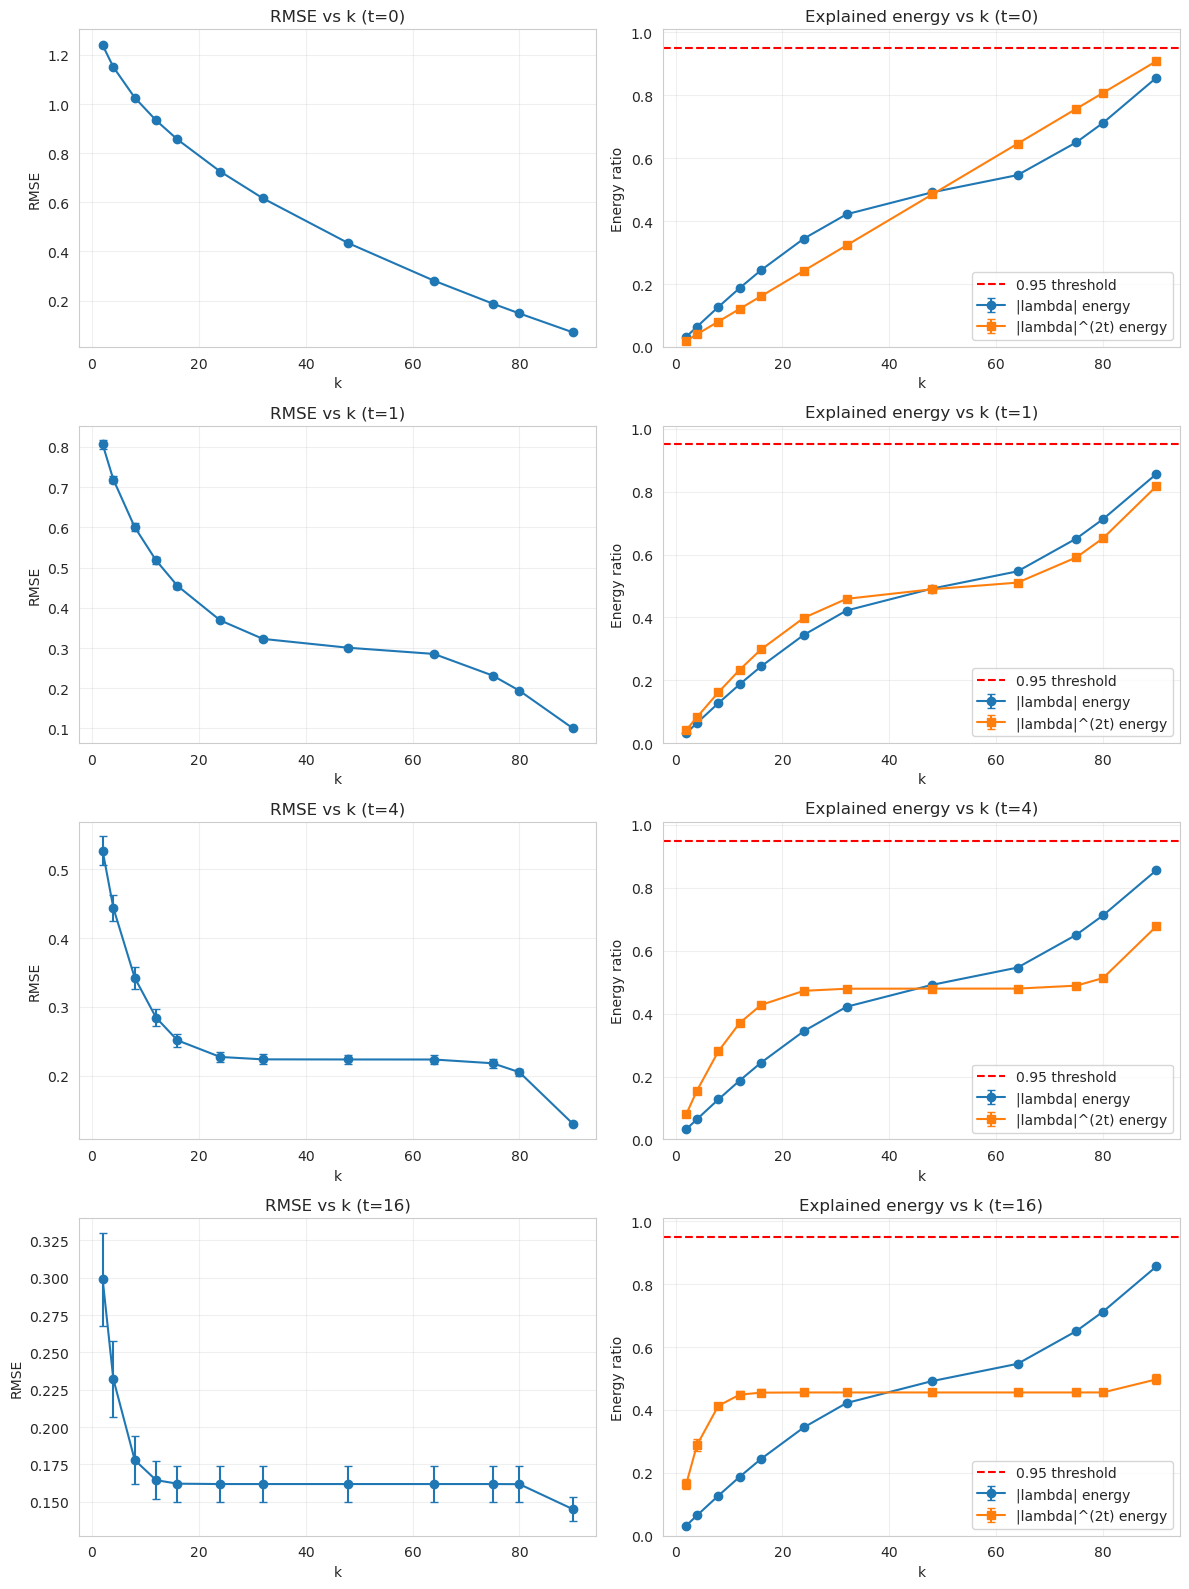

Recommended k at t=0: 90
Recommended k at t=1: 90
Recommended k at t=4: 90
Recommended k at t=16: 90


In [5]:
# Run aggregated experiments
num_trials = 20
L = 100
shortcut_range = (0, 10)
# sweep k; you can adjust
k_values = (2,4,8,12,16,24,32,48,64,75,80,90)
times = (0,1, 4, 16)

agg = aggregate_over_trials(num_trials=num_trials, L=L, shortcut_range=shortcut_range, times=times, k_values=k_values)

# Plot RMSE and energy curves
fig, axes = plt.subplots(len(times), 2, figsize=(12, 4*len(times)))
for row, t in enumerate(times):
    # RMSE
    ax = axes[row, 0]
    ax.errorbar(k_values, agg[int(t)]['rmse_mean'], yerr=agg[int(t)]['rmse_std'], marker='o', capsize=3)
    ax.set_title(f"RMSE vs k (t={t})")
    ax.set_xlabel("k")
    ax.set_ylabel("RMSE")
    ax.grid(True, alpha=0.3)
    
    # Energy (legacy)
    ax = axes[row, 1]
    ax.errorbar(k_values, agg[int(t)]['energy_mean'], yerr=agg[int(t)]['energy_std'], marker='o', capsize=3, label='|lambda| energy')
    # Time-aware energy
    ax.errorbar(k_values, agg[int(t)]['energy_t_mean'], yerr=agg[int(t)]['energy_t_std'], marker='s', capsize=3, label='|lambda|^(2t) energy')
    ax.axhline(0.95, color='r', linestyle='--', label='0.95 threshold')
    ax.set_title(f"Explained energy vs k (t={t})")
    ax.set_xlabel("k")
    ax.set_ylabel("Energy ratio")
    ax.set_ylim(0.0, 1.01)
    ax.grid(True, alpha=0.3)
    ax.legend()
plt.tight_layout()
plt.show()

# Print recommendation per t
for t in times:
    k_rec = recommend_k_from_curves(
        k_values,
        agg[int(t)]['rmse_mean'],
        agg[int(t)]['energy_mean'],
        rmse_thresh=None,
        energy_thresh=0.95,
    )
    print(f"Recommended k at t={t}: {k_rec}")


In [6]:
# Random binary doubly-stochastic sampler and variable-length batching
from typing import List, Tuple
from BondFlow.models.layers import BondingNetwork


def sample_binary_ds_matrix(L: int, offdiag_fraction: float = 0.1) -> Tuple[torch.Tensor, List[Tuple[int, int]]]:
    """
    Generate a symmetric binary doubly-stochastic matrix A (L,L) with most 1s on the diagonal
    and a controllable fraction on off-diagonals via disjoint 2-cycles (i,j).
    Returns A and the list of off-diagonal pairs.
    """
    offdiag_fraction = float(max(0.0, min(1.0, offdiag_fraction)))
    max_pairs = L // 2
    num_pairs = min(int(round(offdiag_fraction * L / 2.0)), max_pairs)

    nodes = list(range(L))
    random.shuffle(nodes)
    pairs = []
    for _ in range(num_pairs):
        if len(nodes) < 2:
            break
        i = nodes.pop()
        j = nodes.pop()
        if i == j:
            continue
        u, v = (i, j) if i < j else (j, i)
        pairs.append((u, v))

    A = torch.zeros((L, L), dtype=torch.float32)
    for (i, j) in pairs:
        A[i, j] = 1.0
        A[j, i] = 1.0
    for i in nodes:
        A[i, i] = 1.0
    return A, pairs


def build_chain_plus_pairs_adj(L: int, pairs: List[Tuple[int, int]]) -> torch.Tensor:
    """
    Build adjacency matrix: sequential chain edges plus specified off-diagonal pairs.
    Self loops are not included.
    """
    A = torch.zeros((L, L), dtype=torch.float32)
    for i in range(L - 1):
        A[i, i+1] = 1.0
        A[i+1, i] = 1.0
    for (i, j) in pairs:
        if i != j:
            A[i, j] = 1.0
            A[j, i] = 1.0
    return A


def pad_batch(mats: List[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Pad a list of (Li,Li) matrices to (B, Lmax, Lmax) and return node_mask (B, Lmax).
    """
    B = len(mats)
    sizes = [m.shape[0] for m in mats]
    Lmax = max(sizes)
    device_ = mats[0].device
    dtype_ = mats[0].dtype
    batch = torch.zeros((B, Lmax, Lmax), dtype=dtype_, device=device_)
    mask = torch.zeros((B, Lmax), dtype=torch.bool, device=device_)
    for b, M in enumerate(mats):
        Lb = M.shape[0]
        batch[b, :Lb, :Lb] = M
        mask[b, :Lb] = True
    return batch, mask


def make_random_batch(batch_size: int,
                      L_min: int = 10,
                      L_max: int = 380,
                      offdiag_frac_range: Tuple[float, float] = (0.0, 0.2),
                      device: torch.device = torch.device('cpu')):
    """
    Create a random batch of variable-sized samples.
    For each sample: sample L, sample a binary DS target and its pairs, build chain+pair adjacency.
    Returns padded adjacency batch, target DS batch, and node_mask.
    """
    Ds = []
    Adjs = []
    for _ in range(batch_size):
        L = int(np.random.randint(L_min, L_max + 1))
        offdiag_frac = float(np.random.uniform(offdiag_frac_range[0], offdiag_frac_range[1]))
        A_tgt, pairs = sample_binary_ds_matrix(L, offdiag_fraction=offdiag_frac)
        A_adj = build_chain_plus_pairs_adj(L, pairs)
        Ds.append(A_tgt.to(device))
        Adjs.append(A_adj.to(device))
    A_adj_batch, node_mask = pad_batch(Adjs)
    D_tgt_batch, _ = pad_batch(Ds)
    return A_adj_batch, D_tgt_batch, node_mask


In [7]:
import torch
from typing import Sequence, Optional

@torch.no_grad()
def diffusion_distance_tensor(
    A_adj_batch: torch.Tensor,            # (B, L, L)
    node_mask: torch.Tensor,              # (B, L)
    times: Sequence[int],                 # e.g., (0,1,4)
    k: int = 256,                          # if -1: use all components except the first when skip_top=True
    skip_top: bool = True,
    eps: float = 1e-12,
    rbf_num: int = 0,                     # if >0, return RBF-embedded distances with this feature dimension
    rbf_gamma: Optional[float] = None,    # if None, auto-set based on spacing
    energy_thresh: Optional[float] = None,# per-sample adaptive k based on spectral energy if set
    k_ratio: Optional[float] = None,      # per-sample adaptive k based on a ratio of available components
    t_ref: Optional[int] = None,          # reference time for energy (default=max(times))
) -> torch.Tensor:
    """Compute diffusion distances at multiple times.

    Args:
      k: number of eigencomponents to use; if -1, use all available (except the top one when skip_top=True).
      rbf_num: number of RBF centers in [0,1]; if 0, return raw distances per t.
      rbf_gamma: Gaussian width; default auto = 1/(2*delta^2) with delta=1/(rbf_num-1).
      energy_thresh: pick smallest k per sample to reach this spectral energy (|lambda|^(2*t_ref)).
      k_ratio: pick smallest k per sample based on a ratio of available components. Overrides energy_thresh.
      t_ref: reference time for energy threshold; default max(times) if None.

    Returns:
      If rbf_num == 0: (B, L, L, T) each slice is D_t in [0,1] (normalized per-batch).
      If rbf_num > 0: (B, L, L, T*rbf_num) RBF features per time.
    """
    from BondFlow.data.utils import diffusion_map_pair_features

    assert A_adj_batch.dim() == 3 and A_adj_batch.shape[-1] == A_adj_batch.shape[-2]
    device = A_adj_batch.device
    dtype = A_adj_batch.dtype
    B, L, _ = A_adj_batch.shape
    # Ensure node_mask on same device
    node_mask = node_mask.to(torch.bool).to(device)

    # Determine effective k for the batch
    if int(k) == -1:
        start = 1 if skip_top else 0
        n_subs = node_mask.sum(dim=1)                     # (B,)
        k_eff = int(n_subs.max().item()) - start         # max valid per-batch minus skipped top
        k_eff = max(k_eff, 1)
    else:
        k_eff = int(k)

    # Reuse eigensolver to get (lam, U) with correct masking/sorting
    _, (lam_all, U_all) = diffusion_map_pair_features(
        A_adj_batch, times=times, k=k_eff, skip_top=skip_top, node_mask=node_mask
    )
    # lam_all: (B, k_eff), U_all: (B, L, k_eff)

    mask_2d = (node_mask[:, :, None] & node_mask[:, None, :])  # (B,L,L)
    
    # Per-sample adaptive k selection
    if k_ratio is not None:
        # Select k based on a fixed ratio of available components
        if energy_thresh is not None:
            print("Warning: Both k_ratio and energy_thresh are provided. k_ratio will take precedence.")
        
        total_avail = (node_mask.sum(dim=1) - (1 if skip_top else 0)).clamp(min=1)
        # Use ceil to ensure at least 1 component is selected for ratio > 0
        k_sel = torch.ceil(total_avail.float() * float(k_ratio)).long().clamp(min=1, max=lam_all.size(1))

        # print(f"\n--- Adaptive k selection based on ratio: {k_ratio:.2f} ---")
        # for i in range(A_adj_batch.shape[0])[:5]:
        #     L_i = int(node_mask[i].sum().item())
        #     total_i = int(total_avail[i].item())
        #     k_sel_i = int(k_sel[i].item())
        #     ratio_i = k_sel_i / total_i if total_i > 0 else 0.0
        #     print(f"Sample {i:2d} (L={L_i:3d}): Selected k={k_sel_i:3d}, Total available={total_i:3d}, Ratio={ratio_i:.4f}")
        # print("--- End of adaptive k report ---\n")

        idx_range = torch.arange(lam_all.size(1), device=device).unsqueeze(0)  # (1,k)
        comp_mask = (idx_range < k_sel.unsqueeze(1)).to(lam_all.dtype)        # (B,k)

        lam_all = lam_all * comp_mask
        U_all = U_all * comp_mask.unsqueeze(1)

    # Per-sample adaptive k via spectral energy threshold (optional)
    elif energy_thresh is not None:
        # Special case for energy_thresh=1.0: select all available components
        # if abs(float(energy_thresh) - 1.0) < 1e-6:
        #     total_avail = (node_mask.sum(dim=1) - (1 if skip_top else 0)).clamp(min=1)
        #     k_sel = total_avail  # Select all available components

        #     # ratio_vs_total = (k_sel.float() / total_avail.float())
        #     # print("\n--- Adaptive k selection (energy_thresh=1.0) ---")
        #     # print("Selecting all available components for each sample.")
        #     # for i in range(A_adj_batch.shape[0]):
        #     #     L_i = int(node_mask[i].sum().item())
        #     #     total_i = int(total_avail[i].item())
        #     #     k_sel_i = int(k_sel[i].item())
        #     #     ratio_i = ratio_vs_total[i].item()
        #     #     print(f"Sample {i:2d} (L={L_i:3d}): Selected k={k_sel_i:3d}, Total available={total_i:3d}, Ratio={ratio_i:.4f}")
        #     # print("--- End of adaptive k report ---\n")

        # else:
        tref = int(max(times) if t_ref is None else t_ref)
        w = lam_all.abs().pow(2 * tref)                        # (B,k_eff)
        
        # For padded components, lambda can be zero. Mask them out from energy calculation.
        idx_range_w = torch.arange(w.size(1), device=device).unsqueeze(0) # (1, k_eff)
        valid_comps = (node_mask.sum(dim=1, keepdim=True) - (1 if skip_top else 0)) # (B, 1)
        w_mask = (idx_range_w < valid_comps).to(w.dtype)
        w = w * w_mask

        denom = w.sum(dim=1, keepdim=True).clamp_min(1e-12)
        ratio = torch.cumsum(w, dim=1) / denom                 # (B,k_eff)
        
        effective_thresh = float(energy_thresh)

        hits = ratio >= effective_thresh
        # default to all components if never reaches threshold
        first_idx = torch.where(hits.any(dim=1), hits.float().argmax(dim=1), torch.full((B,), lam_all.size(1) - 1, device=device, dtype=torch.long))
        k_sel = torch.clamp(first_idx + 1, min=1, max=lam_all.size(1))  # (B,)
        
        total_avail = (node_mask.sum(dim=1) - (1 if skip_top else 0)).clamp(min=1)        # (B,)
        ratio_vs_total = (k_sel.float() / total_avail.float())                # (B,)

        # print("\n--- Adaptive k selection based on energy threshold ---")
        # print(f"Energy threshold: {energy_thresh}, effective: {effective_thresh:.6f}")
        # print(f"Reference time t_ref: {tref}")
        # for i in range(A_adj_batch.shape[0])[:5]:
        #     L_i = int(node_mask[i].sum().item())
        #     total_i = int(total_avail[i].item())
        #     k_sel_i = int(k_sel[i].item())
        #     ratio_i = ratio_vs_total[i].item()
        #     print(f"Sample {i:2d} (L={L_i:3d}): Selected k={k_sel_i:3d}, Total available={total_i:3d}, Ratio={ratio_i:.4f}")
        # print("--- End of adaptive k report ---\n")

        idx_range = torch.arange(lam_all.size(1), device=device).unsqueeze(0)  # (1,k)
        comp_mask = (idx_range < k_sel.unsqueeze(1)).to(lam_all.dtype)        # (B,k)

        lam_all = lam_all * comp_mask
        U_all = U_all * comp_mask.unsqueeze(1)

    dists_per_t = []
    for t in times:
        lam_pow = lam_all.pow(int(t))              # (B,k_eff)
        emb = U_all * lam_pow[:, None, :]          # (B, L, k_eff)
        # Pairwise squared distances via Gram trick
        sq = (emb.pow(2).sum(dim=-1, keepdim=True))         # (B, L, 1)
        gram = torch.matmul(emb, emb.transpose(1, 2))       # (B, L, L)
        dist2 = sq + sq.transpose(1, 2) - 2.0 * gram        # (B, L, L)
        dist2 = torch.clamp(dist2, min=0.0)
        dist = torch.sqrt(dist2 + eps)

        # Zero-out invalid pairs and enforce zero diagonal
        dist = dist * mask_2d.float()
        eye = torch.eye(L, dtype=dist.dtype, device=dist.device).unsqueeze(0)
        dist = dist * (1.0 - eye)
        dists_per_t.append(dist)

    dist_all_t = torch.stack(dists_per_t, dim=-1)  # (B, L, L, T)

    # Normalize distances to [0,1] per-batch for stable RBFs (exclude diagonal)
    dist_valid = dist_all_t.clone()
    mask3 = mask_2d.unsqueeze(-1).expand_as(dist_valid)
    dist_valid = dist_valid * mask3
    B_, L_, _, T_ = dist_valid.shape
    eye3 = torch.eye(L_, device=device, dtype=dtype).view(1, L_, L_, 1)
    dist_valid = dist_valid * (1.0 - eye3)

    # Per-batch max (over i,j,t) for normalization; avoid div by 0
    max_per_b = dist_valid.view(B_, -1).amax(dim=1).clamp_min(1e-6).view(B_, 1, 1, 1)
    dist_norm = (dist_all_t / max_per_b).clamp(0.0, 1.0)

    if int(rbf_num) <= 0:
        return dist_norm.to(device=device, dtype=dtype)

    # Build RBF centers uniformly in [0,1]
    if rbf_num == 1:
        centers = torch.tensor([0.5], device=device, dtype=dtype)
        gamma = torch.tensor(1.0, device=device, dtype=dtype) if rbf_gamma is None else torch.tensor(float(rbf_gamma), device=device, dtype=dtype)
    else:
        centers = torch.linspace(0.0, 1.0, steps=int(rbf_num), device=device, dtype=dtype)
        delta = (1.0 / float(rbf_num - 1))
        gamma = (1.0 / (2.0 * (delta ** 2))) if rbf_gamma is None else float(rbf_gamma)
        gamma = torch.tensor(gamma, device=device, dtype=dtype)

    # Expand to features: exp(-gamma * (d - c)^2) for each center c
    # dist_norm: (B,L,L,T) -> (B,L,L,T,C)
    diff = dist_norm.unsqueeze(-1) - centers.view(1, 1, 1, 1, -1)
    feats_rbf = torch.exp(-gamma * (diff ** 2))
    # Mask invalid pairs
    feats_rbf = feats_rbf * mask3.unsqueeze(-1)

    # Flatten time and centers into feature dim: (B,L,L,T*C)
    B_, L_, _, T_, C_ = feats_rbf.shape
    feats_flat = feats_rbf.view(B_, L_, L_, T_ * C_)
    return feats_flat.to(device=device, dtype=dtype)


In [8]:
def compute_multihop_features(A: torch.Tensor, max_hop: int = 3, include_shortest_path: bool = True) -> torch.Tensor:
    """
    从邻接矩阵计算多跳邻接和最短路径距离特征
    
    Args:
        A: (B, L, L) 邻接矩阵（0/1）
        max_hop: 最大跳数
        include_shortest_path: 是否包含最短路径距离
    
    Returns:
        features: (B, L, L, F) 特征矩阵
            - channels 0~max_hop: k-hop可达性 (0/1)
            - channel max_hop+1 (optional): 归一化最短路径距离
            - channel max_hop+2 (optional): 度数差异特征
    """
    B, L, _ = A.shape
    device = A.device
    
    features = []
    
    # 1. 多跳邻接（k-hop可达性）
    A_power = A.clone()  # A^1
    for hop in range(1, max_hop + 1):
        # k-hop邻接：A^k中非零元素表示k步可达
        reachable = (A_power > 0).float()
        features.append(reachable)
        if hop < max_hop:
            A_power = torch.bmm(A_power, A)  # A^{k+1} = A^k * A
    
    # 2. 最短路径距离（用Floyd-Warshall或BFS近似）
    if include_shortest_path:
        # 初始化距离矩阵
        dist = torch.full((B, L, L), float(L), device=device)
        # 对角线距离为0
        dist[:, torch.arange(L), torch.arange(L)] = 0
        # 直接相连的距离为1
        dist = torch.where(A > 0, torch.ones_like(dist), dist)
        
        # Floyd-Warshall（可以用k=3~5次迭代近似，因为链式图直径不大）
        for k in range(min(L, 10)):  # 限制迭代次数防止计算爆炸
            dist = torch.minimum(dist, dist[:, :, k:k+1] + dist[:, k:k+1, :])
        
        # 归一化到[0,1]
        dist_normalized = dist / (L + 1e-8)
        features.append(dist_normalized)
    
    # 3. 度数特征（节点度数的绝对差异）
    degree = A.sum(dim=-1, keepdim=True)  # (B, L, 1)
    degree_diff = torch.abs(degree - degree.transpose(1, 2))  # (B, L, L)
    degree_diff_normalized = degree_diff / (L + 1e-8)
    features.append(degree_diff_normalized)
    
    # Stack所有特征
    features = torch.stack(features, dim=-1)  # (B, L, L, F)
    
    return features


def compute_local_structural_features(A: torch.Tensor, node_mask: torch.Tensor) -> torch.Tensor:
    """
    计算更丰富的局部结构特征（轻量级版本）
    
    Args:
        A: (B, L, L) 邻接矩阵
        node_mask: (B, L) 节点掩码
    
    Returns:
        features: (B, L, L, F) 包含：
            - 是否直接相连 (1-hop)
            - 是否有共同邻居 (2-hop via common neighbor)
            - 共同邻居数量（归一化）
            - Jaccard相似度（邻居集合相似度）
    """
    B, L, _ = A.shape
    device = A.device
    features = []
    
    # 1. 直接相连（1-hop）
    features.append(A)  # (B, L, L)
    
    # 2. 共同邻居指示（2-hop）
    A_sq = torch.bmm(A, A)  # A^2[i,j] = 共同邻居数量
    has_common_neighbor = (A_sq > 0).float()
    features.append(has_common_neighbor)
    
    # 3. 共同邻居数量（归一化）
    degree = A.sum(dim=-1, keepdim=True).clamp(min=1)  # (B, L, 1)
    common_neighbors_norm = A_sq / degree.max()
    features.append(common_neighbors_norm)
    
    # 4. Jaccard相似度：|N(i) ∩ N(j)| / |N(i) ∪ N(j)|
    intersection = A_sq  # 共同邻居数
    # Union = |N(i)| + |N(j)| - |N(i) ∩ N(j)|
    deg_i = A.sum(dim=-1, keepdim=True)  # (B, L, 1)
    deg_j = A.sum(dim=-2, keepdim=True)  # (B, 1, L)
    union = deg_i + deg_j - intersection
    jaccard = intersection / (union.clamp(min=1))
    features.append(jaccard)
    
    # Stack并应用mask
    features = torch.stack(features, dim=-1)  # (B, L, L, F)
    mask_2d = node_mask[:, :, None] & node_mask[:, None, :]  # (B, L, L)
    features = features * mask_2d.unsqueeze(-1).float()
    
    return features


In [9]:
import torch
from typing import Tuple

def sample_binary_ds_batched(
    Ls: torch.Tensor,                 # (B,)
    offdiag_fracs: torch.Tensor,      # (B,) in [0,1]
    device=None,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    生成对称二值双随机矩阵（主要在对角，少量非对角2-cycle），张量化版本。
    返回:
      - D: (B, Lmax, Lmax) 二值DS矩阵（超出L的padding位置为0）
      - pairs_i, pairs_j: (B, Kmax) 每个样本的非对角2-cycle下标（无效用-1占位）
      - node_mask: (B, Lmax) True表示有效结点
    """
    device = device or Ls.device
    B = Ls.shape[0]
    Lmax = int(Ls.max().item())

    node_mask = torch.arange(Lmax, device=device).unsqueeze(0) < Ls.unsqueeze(1)  # (B,Lmax)

    # 每样本2-cycle个数 m = min(round(frac*L/2), floor(L/2))
    half_L = (Ls // 2)
    m = torch.round(offdiag_fracs * (Ls.float() / 2.0)).long().clamp(min=0)
    m = torch.minimum(m, half_L)
    Kmax = Lmax // 2

    # 为每个样本生成随机排列（无效位置加inf，排序后有效在前）
    keys = torch.rand(B, Lmax, device=device).masked_fill(~node_mask, float('inf'))
    order = torch.argsort(keys, dim=1)                        # (B,Lmax)
    take = min(2 * Kmax, Lmax)
    order2 = order[:, :take]
    pair_i_all = order2[:, 0:take:2]                          # (B,Kmax)
    pair_j_all = order2[:, 1:take:2]                          # (B,Kmax)

    # 有效pair掩码
    pair_pos = torch.arange(Kmax, device=device).unsqueeze(0).expand(B, -1)
    pair_valid = pair_pos < m.unsqueeze(1)                    # (B,Kmax)

    # 初始化为单位阵（仅有效结点）
    D = torch.zeros(B, Lmax, Lmax, device=device)
    idx = torch.arange(Lmax, device=device)
    D[:, idx, idx] = node_mask.float()

    # 应用2-cycle：置对角为0，并在(i,j),(j,i)置1
    b_idx = torch.arange(B, device=device).unsqueeze(1).expand_as(pair_i_all)[pair_valid]
    ii = pair_i_all[pair_valid]
    jj = pair_j_all[pair_valid]
    D[b_idx, ii, ii] = 0.0
    D[b_idx, jj, jj] = 0.0
    D[b_idx, ii, jj] = 1.0
    D[b_idx, jj, ii] = 1.0

    pairs_i = torch.where(pair_valid, pair_i_all, torch.full_like(pair_i_all, -1))
    pairs_j = torch.where(pair_valid, pair_j_all, torch.full_like(pair_j_all, -1))
    return D, pairs_i, pairs_j, node_mask

def build_chain_plus_pairs_adj_batched(
    Ls: torch.Tensor,
    pairs_i: torch.Tensor,  # (B,Kmax), -1无效
    pairs_j: torch.Tensor,  # (B,Kmax), -1无效
    node_mask: torch.Tensor # (B,Lmax)
) -> torch.Tensor:
    """
    批量构造邻接 = 链式(|i-j|=1) + 指定2-cycle边。无自环。
    """
    device = node_mask.device
    B, Lmax = node_mask.shape

    base = torch.zeros(Lmax, Lmax, device=device)
    idx = torch.arange(Lmax, device=device)
    base[idx[:-1], idx[1:]] = 1.0
    base[idx[1:], idx[:-1]] = 1.0

    A = base.unsqueeze(0).expand(B, -1, -1) * (node_mask.unsqueeze(1) & node_mask.unsqueeze(2)).float()

    valid = pairs_i >= 0
    b_idx = torch.arange(B, device=device).unsqueeze(1).expand_as(pairs_i)[valid]
    ii = pairs_i[valid]
    jj = pairs_j[valid]
    A[b_idx, ii, jj] = 1.0
    A[b_idx, jj, ii] = 1.0
    return A

def make_random_batch_batched(
    batch_size: int,
    L_min: int = 10,
    L_max: int = 380,
    offdiag_frac_range=(0.0, 0.2),
    device=torch.device('cpu')
):
    """
    完全张量化批量采样：
      返回 A_adj_batch, D_tgt_batch, node_mask
    """
    Ls = torch.randint(L_min, L_max + 1, (batch_size,), device=device)
    fracs = torch.empty(batch_size, device=device).uniform_(*offdiag_frac_range)
    D, pi, pj, node_mask = sample_binary_ds_batched(Ls, fracs, device=device)
    A = build_chain_plus_pairs_adj_batched(Ls, pi, pj, node_mask)
    return A, D, node_mask

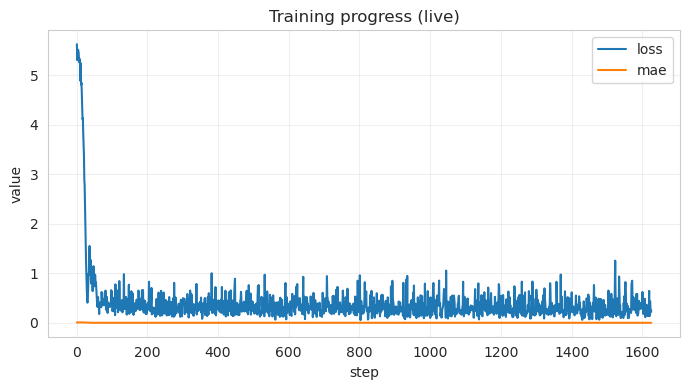

feats.shape:  torch.Size([16, 380, 380, 600])
real offdiagonal tensor(0.9169, device='cuda:0', grad_fn=<DivBackward0>)
pred bond_mat > 0.5 num  tensor(176., device='cuda:0') real bond_mat > 0.5 num  tensor(186., device='cuda:0')
bond_mat > 0.5 mean:  tensor(0.9566, device='cuda:0', grad_fn=<DivBackward0>)
pred>0.5中被real>0.5包含的比例: 0.9462（1为全包含）
pred>0.5中落在real<=0.5外面的比例: 0.0000（0为全包含）


OutOfMemoryError: CUDA out of memory. Tried to allocate 21.87 GiB. GPU 0 has a total capacity of 79.32 GiB of which 18.84 GiB is free. Including non-PyTorch memory, this process has 39.69 GiB memory in use. Process 3260150 has 20.78 GiB memory in use. Of the allocated memory 27.92 GiB is allocated by PyTorch, and 11.09 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
# Wire diffusion_map_pair_features -> BondingNetwork and train with DSMCrossEntropyLoss
from BondFlow.data.utils import diffusion_map_pair_features
from BondFlow.models.Loss import DSMCrossEntropyLoss
import torch.nn as nn
import os

# Mitigate fragmentation (set early in session if possible)
os.environ.setdefault('PYTORCH_CUDA_ALLOC_CONF', 'expandable_segments:True')

# Hyperparams (memory-safe defaults)
batch_size = 16
k_eigs = 200
times = (1,2,4,5,16,17,)           # compute only t=1
rbf_num = 100        # RBF embedding dim per t (0 -> disabled)
rbf_gamma = None         # None -> auto from centers spacing
lr = 2e-4
steps = 10000
offdiag_range = (0.0, 0.1)
L_min, L_max = 10, 400 # scale up gradually once stable



def build_mask_2d(node_mask: torch.Tensor) -> torch.Tensor:
    return node_mask[:, :, None] & node_mask[:, None, :]

@torch.no_grad()
def get_feats_cpu(A_adj_batch: torch.Tensor, node_mask: torch.Tensor):
    # Heavy eigendecomp on CPU without grad, then move+cast to GPU in half
    #feats_cpu, _ = diffusion_map_pair_features(A_adj_batch, times=times, k=k_eigs, skip_top=True, node_mask=node_mask.cpu())
    feats_cpu = diffusion_distance_tensor(
        A_adj_batch, node_mask=node_mask, times=times, k=k_eigs, skip_top=True,
        rbf_num=rbf_num, rbf_gamma=rbf_gamma, #energy_thresh = 0.9999, t_ref=1,
           k_ratio=0.6
    )
    return feats_cpu.to(device=device, dtype=(A_adj_batch.dtype), non_blocking=True)

# Init model after probing feature dim
A_adj_batch, D_tgt_batch, node_mask = make_random_batch_batched(batch_size, L_min=L_min, L_max=L_max, offdiag_frac_range=offdiag_range, device=device)
feats_probe = get_feats_cpu(A_adj_batch, node_mask)
F_pair = feats_probe.shape[-1]

d_pair = 256
preproj = nn.Sequential(
    nn.Linear(F_pair, d_pair),
    nn.GELU(),
    nn.Linear(d_pair, d_pair),
    nn.GELU(),
    nn.Linear(d_pair, d_pair),
    # nn.LayerNorm(d_pair),
).to(device)
bond_net = BondingNetwork(d_msa=128, d_state=None, d_pair=d_pair, p_drop=0.0).to(device)
crit = DSMCrossEntropyLoss(gamma=0.5, off_diagonal_weight=1)
opt = torch.optim.Adam(list(preproj.parameters()) + list(bond_net.parameters()), lr=lr)
# Live plotting of loss/MAE during training
from IPython.display import clear_output
import matplotlib.pyplot as plt

loss_hist, mae_hist, step_hist = [], [], []

# You can override steps_live/plot_every without touching the earlier cell
steps_live = steps if 'steps' in globals() else 600
plot_every = 5

# Cosine annealing LR schedule
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps_live, eta_min=max(lr * 0.1, 1e-5))

for step in range(1, steps_live + 1):
    # Fresh random batch (variable L) — uses non-batched generator for simplicity
    A_adj_batch, D_tgt_batch, node_mask = make_random_batch(
        batch_size,
        L_min=L_min,
        L_max=L_max,
        offdiag_frac_range=offdiag_range,
        device=device,
    )
    mask_2d = build_mask_2d(node_mask)

    # Features and forward
    lll = D_tgt_batch * (1 - torch.eye(D_tgt_batch.shape[1], D_tgt_batch.shape[2], device=device).repeat(D_tgt_batch.shape[0], 1, 1))
    feats= get_feats_cpu(A_adj_batch, node_mask)
    #feats = diffusion_distance_tensor(A_adj_batch, node_mask=node_mask, times=times, k=k_eigs, skip_top=True)
    print("feats.shape: ", feats.shape)
    feats_emb = preproj(feats)
    pred = bond_net(msa=None, state=None, pair=feats_emb, mask_2d=mask_2d)

    # Loss
    loss = crit(pred, D_tgt_batch, mask_2d)
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step()
    # Proactive cleanup of large tensors
    del feats, feats_emb
    if (step % 1 == 0) and (device.type == 'cuda'):
        torch.cuda.empty_cache()
    eye = torch.eye(pred.shape[1], pred.shape[2], device=device).repeat(pred.shape[0], 1, 1)
    print("pred bond_mat > 0.5 num ", ((pred * (1-eye)) > 0.5).float().sum(), "real bond_mat > 0.5 num ", (D_tgt_batch * (1-eye) > 0.5).float().sum())
    print("bond_mat > 0.5 mean: ", pred[(pred * (1-eye) )> 0.5].float().sum()/(pred * (1-eye)  > 0.5).float().sum().clamp(min=1))
    # 判断 pred > 0.5 的那些位置，是否都在 real > 0.5 为 True 的位置上
    # 实际就是 pred>0.5 的位置上，real 是否也>0.5
    pred_mask = (pred * (1 - eye)) > 0.5
    real_mask = (D_tgt_batch * (1 - eye)) > 0.5

    # pred > 0.5 的这些位置是否都包含在 real > 0.5 的位置上（inclusion）
    overlap = (real_mask & pred_mask).float().sum()
    real_count = real_mask.float().sum().clamp(min=1)  # 防止0除
    inclusion_ratio = overlap / real_count

    # 看看有没有 pred > 0.5 但 real <= 0.5 的（即 pred > 0.5 在 real > 0.5 外面的个数和比例）
    outside = (pred_mask & (~real_mask)).float().sum()
    outside_ratio = outside / real_count

    print(f"pred>0.5中被real>0.5包含的比例: {inclusion_ratio.item():.4f}（1为全包含）")
    print(f"pred>0.5中落在real<=0.5外面的比例: {outside_ratio.item():.4f}（0为全包含）")
    # Metrics
    with torch.no_grad():
        diff = (pred - D_tgt_batch).abs() * mask_2d
        denom = mask_2d.sum().clamp(min=1).float()
        mae = (diff.sum() / denom).item()

    loss_hist.append(loss.item())
    mae_hist.append(mae)
    step_hist.append(step)

    # Live plot
    if step % plot_every == 0 or step == 1:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7,4))
        ax.plot(step_hist, loss_hist, label='loss')
        ax.plot(step_hist, mae_hist, label='mae')
        ax.set_xlabel('step')
        ax.set_ylabel('value')
        ax.set_title('Training progress (live)')
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.show()

print('Final loss:', loss_hist[-1], 'Final MAE:', mae_hist[-1])


In [ ]:
# Evaluation on a fresh random batch
A_adj_batch, D_tgt_batch, node_mask = make_random_batch_batched(batch_size, L_min=L_min, L_max=L_max, offdiag_frac_range=offdiag_range, device=device)
mask_2d = build_mask_2d(node_mask)
#feats, _ = diffusion_map_pair_features(D_tgt_batch, times=times, k=k_eigs, skip_top=True, node_mask=node_mask)
feats = diffusion_distance_tensor(
    A_adj_batch, node_mask=node_mask, times=times, k=k_eigs, skip_top=True,
    rbf_num=rbf_num, rbf_gamma=rbf_gamma,
)
feats_emb = preproj(feats)
with torch.no_grad():
    pred = bond_net(msa=None, state=None, pair=feats_emb, mask_2d=mask_2d)

# visualize first sample
from BondFlow.data.utils import plot_tensor_heatmap
pred0 = pred[0, :node_mask[0].sum(), :node_mask[0].sum()].detach().cpu()
tgt0 = D_tgt_batch[0, :node_mask[0].sum(), :node_mask[0].sum()].detach().cpu()
plot_tensor_heatmap(tgt0, title="Target DS (binary)")
plot_tensor_heatmap(pred0, title="Predicted DS (BondingNetwork)")


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.66 GiB. GPU 0 has a total capacity of 79.32 GiB of which 21.64 GiB is free. Including non-PyTorch memory, this process has 57.67 GiB memory in use. Of the allocated memory 47.46 GiB is allocated by PyTorch, and 9.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Sweep k_eigs, times, rbf_num to study first-100-step convergence
import itertools
import time
from collections import defaultdict

from BondFlow.models.layers import BondingNetwork
from BondFlow.models.Loss import DSMCrossEntropyLoss

@torch.no_grad()
def compute_feats(A_adj_batch, node_mask, times, k_eigs, rbf_num, rbf_gamma=None):
    return diffusion_distance_tensor(
        A_adj_batch,
        node_mask=node_mask,
        times=times,
        k=int(k_eigs),
        skip_top=True,
        rbf_num=int(rbf_num),
        rbf_gamma=rbf_gamma,
    )


def run_one_config(
    k_eigs:int,
    times:tuple,
    rbf_num:int,
    steps:int=100,
    batch_size:int=16,
    L_min:int=60,
    L_max:int=60,
    lr:float=2e-4,
    d_pair:int=256,
    offdiag_range=(0.0, 0.2),
):
    # Probe feature dim
    A_adj_batch, D_tgt_batch, node_mask = make_random_batch_batched(
        batch_size=batch_size, L_min=L_min, L_max=L_max, offdiag_frac_range=offdiag_range, device=device
    )
    feats_probe = compute_feats(A_adj_batch, node_mask, times, k_eigs, rbf_num)
    F_pair = int(feats_probe.shape[-1])

    # Build model
    preproj = nn.Sequential(
        nn.Linear(F_pair, d_pair),
        nn.GELU(),
        nn.LayerNorm(d_pair),
    ).to(device)
    bond_net = BondingNetwork(d_msa=128, d_state=None, d_pair=d_pair, p_drop=0.0).to(device)
    crit = DSMCrossEntropyLoss(gamma=2, off_diagonal_weight=10)
    opt = torch.optim.Adam(list(preproj.parameters()) + list(bond_net.parameters()), lr=lr)

    loss_hist = []

    for step in range(1, steps + 1):
        # Fresh random batch
        A_adj_batch, D_tgt_batch, node_mask = make_random_batch(
            batch_size=batch_size,
            L_min=L_min,
            L_max=L_max,
            offdiag_frac_range=offdiag_range,
            device=device,
        )
        mask_2d = node_mask[:, :, None] & node_mask[:, None, :]

        # Features
        feats = compute_feats(A_adj_batch, node_mask, times, k_eigs, rbf_num)
        feats = feats.to(device=device, dtype=A_adj_batch.dtype, non_blocking=True)
        feats_emb = preproj(feats)

        pred = bond_net(msa=None, state=None, pair=feats_emb, mask_2d=mask_2d)
        loss = crit(pred, D_tgt_batch, mask_2d)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_hist.append(float(loss.item()))

        # Cleanup large tensors
        del feats, feats_emb, pred
        if (step % 10 == 0) and (device.type == 'cuda'):
            torch.cuda.empty_cache()

    return loss_hist


# Compact sweep (8 runs): adjust if you need more coverage
k_list = [16, 64]
times_list = [(1,), (1,4,16)]
rbf_list = [0, 32]

sweep_results = {}
start_all = time.time()
for k_val in k_list:
    for times_val in times_list:
        for rbf_val in rbf_list:
            key = f"k={k_val}|times={list(times_val)}|rbf={rbf_val}"
            print(f"Running {key} ...", flush=True)
            t0 = time.time()
            loss_curve = run_one_config(
                k_eigs=k_val,
                times=tuple(int(t) for t in times_val),
                rbf_num=rbf_val,
                steps=100,
                batch_size=16,
                L_min=60,
                L_max=60,
                lr=2e-4,
                d_pair=256,
                offdiag_range=(0.0, 0.2),
            )
            dt = time.time() - t0
            sweep_results[key] = {
                'loss': loss_curve,
                'final_loss': float(loss_curve[-1]),
                'time_sec': float(dt),
                'k_eigs': int(k_val),
                'times': list(int(t) for t in times_val),
                'rbf_num': int(rbf_val),
            }
            print(f"Done {key}: final_loss={loss_curve[-1]:.4f}, time={dt:.1f}s")

print(f"Total sweep time: {time.time()-start_all:.1f}s for {len(sweep_results)} runs")

# Plot convergence curves grouped by `times`
fig, axes = plt.subplots(len(times_list), 1, figsize=(8, 3.5*len(times_list)), sharex=True)
if len(times_list) == 1:
    axes = [axes]

for ax, times_val in zip(axes, times_list):
    subset = [(k, r, k2) for (k2, v) in sweep_results.items() if f"times={list(times_val)}" in k2]
    for key, res in sweep_results.items():
        if f"times={list(times_val)}" not in key:
            continue
        k_str = key.split('|')[0]
        rbf_str = key.split('|')[2]
        label = f"{k_str}, {rbf_str}"
        ax.plot(range(1, len(res['loss'])+1), res['loss'], label=label)
    ax.set_title(f"Convergence (first 100 steps) for times={list(times_val)}")
    ax.set_ylabel('loss')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
axes[-1].set_xlabel('step')
plt.tight_layout()
plt.show()

# Print sorted summary by final loss
summary = sorted(((v['final_loss'], k) for k, v in sweep_results.items()))
print("\nConfigs sorted by final loss (lower is better):")
for fin, k in summary:
    print(f"{fin:.4f} :: {k}")
